In [1]:
%load_ext autoreload
%matplotlib inline

In [245]:
import os,sys,glob
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import xarray as xr
import pickle 
from math import *
import warnings

from scipy.optimize import curve_fit
# from scipy.ndimage import gaussian_filter
from scipy.signal import argrelextrema


In [3]:
## Add own library to path
workdir = os.getcwd()
repodir = workdir
projectname = 'aggregation-time-scale'
while os.path.basename(repodir) != projectname:
    repodir = os.path.dirname(repodir)
print('repo:',repodir)
thismodule = sys.modules[__name__]
## Own functions
moduledir = os.path.join(repodir,'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])

repo: /Users/bfildier/Code/analyses/aggregation-time-scale
Own modules available: ['plot2D', 'conditionalstats', 'moistdryedge']


In [4]:
# local input directory
inputdir = os.path.join(repodir,'input','irene')
figdir = os.path.join(repodir,'figures')
moviedir = os.path.join(repodir,'movies')
resultdir = os.path.join(repodir,'results')

# ## Load own libraries
# from moistdryedge import *
# from conditionalstats import *
# from plot2D import *

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

In [5]:
edgevar = 'PW'
# edgevar = 'CRH'

# refvars = 'PW','CRH'

In [227]:
# simname = 'SAM6113_RCE_SST303d1p0r1'
# simname = 'SAM6113_RCE_SST305d1p0r1'
# simname = 'SAM6113_RCE_SST305d2p0r1'
simname = 'SAM6113_RCE_SST307d1p0r1'

def getDtype(simname):
    return simname[-5:-4]

##-- number of processors
nproc = 256
# nproc = 128
print('nprocs: %d'%nproc)

# get sim-dependent variables
caseid = '_'.join(simname.split('_')[1:])
print('caseid:',caseid)
simdir = os.path.join(inputdir,simname+'.0')
inputfile2D = "%s_%d.2Dcom_1.nc"%(caseid,nproc)

nprocs: 256
caseid: RCE_SST307d1p0r1


In [228]:
print('load 2D data')
data2D = xr.open_dataset(os.path.join(simdir,inputfile2D))
time = data2D.time.values

load 2D data


In [229]:
print("load edge")
file_edge = os.path.join(resultdir,simname,"edge_%s.p"%edgevar)
setattr(thismodule,"edge",pickle.load(open(file_edge,"rb")))

load edge


## Criterion to pick initial time

In [244]:
def findBeginEndIndices(vec,width=4):

    # smooth input vector
    vec_smooth = np.convolve(vec,np.linspace(1/width,1/width,width),mode='same')
    if getDtype(simname) == '1':
        n = 2
        vec_smooth2 = np.convolve(vec,np.linspace(1/(n*width),1/(n*width),(n*width)),mode='same')
    else:
        vec_smooth2 = vec_smooth
        
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # find local minima, if any
        locmins = argrelextrema(vec_smooth,np.less)[0]
        # find local maxima, if any
        locmaxs = list(argrelextrema(vec_smooth2,np.greater)[0])

    if len(locmins) == 0:
        i_min = np.argmax(np.logical_not(np.isnan(vec))) # first non-nan element
    else:
        i_min = locmins[0]

    if len(locmaxs) == 0:
        i_max = -np.argmax(np.logical_not(np.isnan(np.flipud(vec))))
    else:
        # only accept a window > 10
        while len(locmaxs)>0 and locmaxs[0]<i_min+10:
            del locmaxs[0]
        # pick first local max
        i_max = locmaxs[0]

    return i_min, i_max, vec_smooth

investigate criterion based on number of points detected on boundary -- local min towards the beginning of the simulation?
take first local min as beginning
11.0
47.0


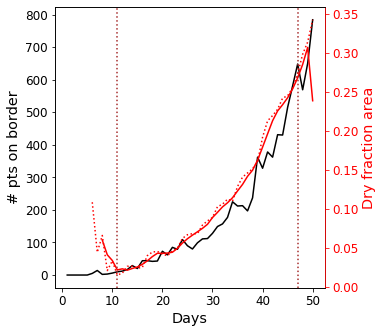

In [246]:
print("Investigate criterion based on number of points detected on boundary -- local min towards the beginning of the simulation?")

Npts = [len(edge.edges[i].border_i) for i in range(len(edge.edges))]

print("take first local min as beginning")
i_min,i_max,fracarea_smooth = findBeginEndIndices(edge.fracarea_PW,4)
print(time[i_min])
print(time[i_max])

fig,ax = plt.subplots(figsize=(5,5))
ax.plot(time,Npts,'k')
ax.set_ylabel('# pts on border')
ax.set_xlabel('Days')

# Fraction area
ax_r = ax.twinx()
ax_r.plot(time,edge.fracarea_PW,'r:')
ax_r.plot(time,fracarea_smooth,'r')
ax_r.set_ylabel('Dry fraction area')
# show first local minimum
ax_r.axvline(time[i_min],c='brown',linestyle=':')
# show first local maximum
ax_r.axvline(time[i_max],c='brown',linestyle=':')

ax_r.yaxis.label.set_color('red')
ax_r.spines['right'].set_edgecolor('r')
ax_r.tick_params(axis='y',colors='r')

plt.savefig(os.path.join(figdir,simname,"procedure_find_range_for_fit_%s.pdf"%edgevar),bbox_inches='tight')

## Fit exponential

In [240]:
print("fit exponential")

t = data2D.time
area = getattr(edge,"fracarea_%s"%edgevar)

print("define beginning of range as local min")
i_tmin,i_tmax,area_smooth = findBeginEndIndices(area,4)
# define slice
s_t = slice(i_tmin,i_tmax)

# model
def model(t,t0,tau):
    return (t-t0)/tau

# fitting function
def fit(x,y):

    valid = np.logical_not(np.logical_or(np.isnan(x),np.isnan(y))).values

    x_no_nans = x[valid]
    y_no_nans = y[valid]

    x2fit = x_no_nans.astype(np.float64)
    y2fit = np.log(y_no_nans).astype(np.float64)

    x0 = (1,1)

    fit, pcov = curve_fit(model, x2fit, y2fit,p0=x0, method='lm')
    
    return fit,pcov

# compute
params,cov = fit(t[s_t],area[s_t])
t0,tau = params
std_t0, std_tau = np.sqrt(np.diag(cov))

print()
print('t0 =',t0)
print('tau =',tau)
print('sigma(t0) =',std_t0)
print('sigma(tau) =',std_tau)

fit exponential
define beginning of range as local min

t0 = 61.51750356709059
tau = 12.95804978428265
sigma(t0) = 0.9244053905116864
sigma(tau) = 0.3383375903724934


/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:77: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, plus)
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:78: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, minus)
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:77: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, plus)
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:78: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, minus)


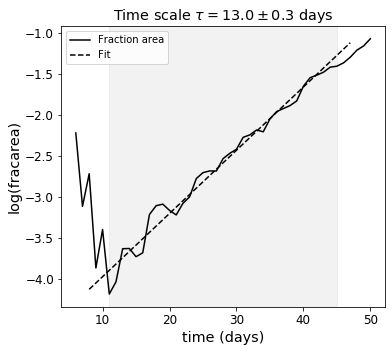

In [241]:
s_tplot = slice(max(i_tmin-3,0),min(i_tmax+3,len(t)))

fig,ax = plt.subplots(figsize=(6,5))

# show range of times used for regression
ax.axvspan(t[i_tmin], t[i_tmax], alpha=0.05, color='k')
# show fraction area and fit
ax.plot(t,np.log(area),'k',label='Fraction area')
ax.plot(t[s_tplot],(t[s_tplot]-t0)/tau,'k--',label='Fit')

# labels
ax.set_ylabel('log(fracarea)')
ax.set_xlabel('time (days)')
ax.set_title(r'Time scale $\tau=%2.1f\pm%2.1f$ days'%(tau,std_tau))

ax.legend()

plt.savefig(os.path.join(figdir,simname,"fit_log_fracarea_%s.pdf"%edgevar),bbox_inches='tight')
plt.show()

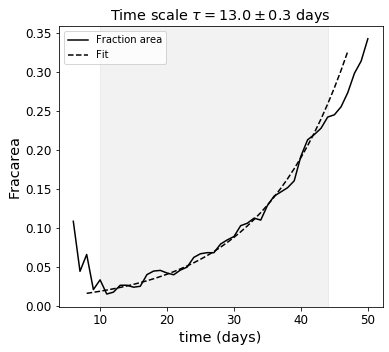

In [242]:
s_tplot = slice(max(i_tmin-3,0),min(i_tmax+3,len(t)))

fig,ax = plt.subplots(figsize=(6,5))

# show range of times used for regression
ax.axvspan(i_tmin, i_tmax, alpha=0.05, color='k')
# show fraction area and fit
ax.plot(t,area,'k',label='Fraction area')
ax.plot(t[s_tplot],np.exp((t[s_tplot]-t0)/tau),'k--',label='Fit')

# labels
ax.set_ylabel('Fracarea')
ax.set_xlabel('time (days)')
ax.set_title(r'Time scale $\tau=%2.1f\pm%2.1f$ days'%(tau,std_tau))

ax.legend()

plt.savefig(os.path.join(figdir,simname,"fit_fracarea_%s.pdf"%edgevar),bbox_inches='tight')
plt.show()

In [243]:
print("save timescale")

savename = "exp_fit_params_%s.p"%edgevar
pickle.dump((t0,tau),open(os.path.join(resultdir,simname,savename),"wb"))
savename = "std_exp_fit_params_%s.p"%edgevar
pickle.dump((std_t0,std_tau),open(os.path.join(resultdir,simname,savename),"wb"))

save timescale
